In [88]:
import cv2
import numpy as np

In [90]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import cv2
import os
import tensorflow as tf
from glob import glob
from tqdm import tqdm
import time
import tensorflow.keras.backend as K

In [111]:
model_files = ["/home/radhika/strykathon/unet/updt/unet_jacc_1.keras",
               "/home/radhika/strykathon/unet/updt/unet_jacc_N2.h5",
               "/home/radhika/strykathon/unet/updt/unet_jacc_N3.h5",
               "/home/radhika/strykathon/unet/updt/unet_jacc_N5.h5"]

classes_and_colors = np.array([[0,0,0] ,[255,0,0], [25,155,187], 
                      [125,255,0], [125,255,255], [175,15,123],
                      [141,255,12] ])

In [112]:
height = 1024//4
width = 1280//4

label = 2
img_path = '/home/radhika/strykathon/unet/dataset/train/frames/frame000_seq_1.png'
label_path = '/home/radhika/strykathon/unet/dataset/train/labels/frame000_seq_1.png'
train_path = '/home/radhika/strykathon/unet/dataset/train'
model_path = os.path.join('/home/radhika/strykathon/unet/model', f'unet_jacc_{label}.keras')
# log_path = os.path.join('./log/', f'log_{label}.csv')
# save_path = './save/'

In [113]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [94]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [103]:
def dice_loss(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    dice = (2. * intersection + smooth) / (sum_ + smooth)
    return 1 - dice

In [116]:
def load_model(model_path : str, jacc = 0):
    if jacc == 0:
        return tf.keras.models.load_model(model_path, custom_objects={'jaccard_distance': jaccard_distance})
    else:
        return tf.keras.models.load_model(model_path, custom_objects={'dice_loss': dice_loss})


In [118]:
def change_color_of_binary_mask(image : list, class_id : int):
    #image = np.squeeze(image,axis=-1)
    return np.array([ [ classes_and_colors[class_id] if pixel == 255 \
            else classes_and_colors[0] for pixel in row ] for row in image ])

(1024, 1280)


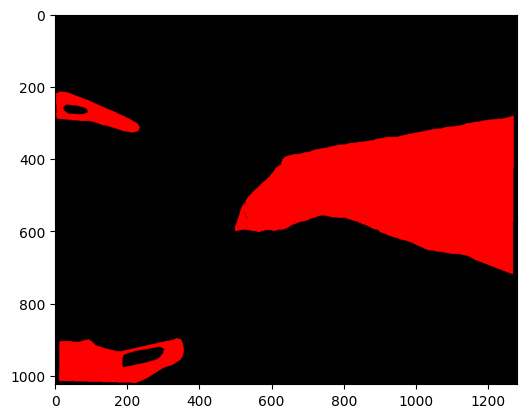

In [119]:
image_path = r"/home/radhika/strykathon/unet/dataset/train/labels1/frame000_seq_1.png"
image = cv2.imread(image_path,0)
print ( image.shape )
img = change_color_of_binary_mask(image,1)
plt.imshow(img)

In [120]:
def get_class_wise_predicted_mask ( x , class_id, jacc ) :
    name = x.split('/')[-1]
    
    x = cv2.imread ( x , cv2.IMREAD_COLOR )
    x = cv2.resize ( x , ( width , height ) )
    x = x / 255.0
    x = np.expand_dims ( x , axis = 0 )
    
    model = load_model(model_files[class_id-1],jacc)
    print(model_files[class_id-1])

    p = model.predict(x)[0]
    
    p = p > 0.5
    p = p * 255

    p = np.squeeze(p,axis=-1)

    colored_mask = change_color_of_binary_mask( p ,class_id)
    
    return colored_mask.astype(np.uint8)

In [121]:
predicted_mask = get_class_wise_predicted_mask ( r"/home/radhika/strykathon/unet/dataset/train/frames/frame000_seq_1.png",1, jacc = 0 )
# plt.imshow(predicted_mask)
#predicted_mask = predicted_mask.astype(np.uint8)
cv2.imshow("random",predicted_mask)
cv2.waitKey(5000)
cv2.destroyAllWindows()

/home/radhika/strykathon/unet/updt/unet_jacc_1.keras
1/1 [==============================] - 1s 601ms/step


In [127]:
import numpy as np
from functools import reduce

def concatenate_masks( first_mask, second_mask ):
    return [[ second_mask [ row_index ][ col_index ] or pixel \
            for col_index , pixel in enumerate ( row ) ]\
            for row_index , row in enumerate ( first_mask ) ]

def concatenate_masks_rgb(first_mask, second_mask):
    return [[
        [second_mask[row_index][col_index][channel] or pixel[channel]
         for channel in range(3)]  # Iterate over RGB channels
        for col_index, pixel in enumerate(row)]
        for row_index, row in enumerate(first_mask)]

def concatenate_class_wise_masks ( image_path : str, num_of_classes = 6 ):
    jacc_class = [ '',0,1,0,1 ]
    image = cv2.imread ( image_path )
    h, w, _ = image.shape

    blank_canvas = np.zeros(( 256 , 320, 3 ))

    predicted_masks = [ get_class_wise_predicted_mask( image_path, class_id, jacc = jacc_class[class_id] ) \
                       for class_id in range ( 1 , num_of_classes + 1 )]  
    
    predicted_masks.append(blank_canvas)

    #plt.imshow(predicted_masks[0])
    #plt.imshow(predicted_masks[1])
                                
    return np.array(reduce( concatenate_masks_rgb , predicted_masks ))


In [131]:
import cv2
image_path = "/home/radhika/strykathon/unet/dataset/train/frames/frame000_seq_7.png"
final_img = concatenate_class_wise_masks ( image_path, 3 )
cv2.imshow ( "Image", final_img )
cv2.waitKey(5000)
cv2.destroyAllWindows()

/home/radhika/strykathon/unet/updt/unet_jacc_1.keras
1/1 [==============================] - 1s 606ms/step
/home/radhika/strykathon/unet/updt/unet_jacc_N2.h5
1/1 [==============================] - 1s 610ms/step
/home/radhika/strykathon/unet/updt/unet_jacc_N3.h5
1/1 [==============================] - 1s 591ms/step


In [130]:
l = [1,2,3,4,5]
def add ( x , y ): return x + y
reduce(add,l)


15

In [57]:
def change_color_of_binary_mask(image_path : str, class_id : int):
    image = cv2.imread ( image_path , 0 )
    return np.array([ [ classes_and_colors[class_id] if pixel == 255 \
            else classes_and_colors[0] for pixel in row ] for row in image ])

In [79]:

def _change_color_of_binary_mask(image_path: str, class_id : int):
    # Read the image as grayscale
    mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask_rgb = np.stack([mask] * 3, axis=-1)
    
    # Change the color of white pixels in the mask to the specified color
    mask_rgb[mask == 255] = classes_and_colors[ class_id ]
    
    return mask_rgb

In [81]:
import cv2
import numpy as np
from functools import reduce

images = ["/home/radhika/strykathon/unet/dataset/train/labels1/frame000_seq_7.png",
          "/home/radhika/strykathon/unet/dataset/train/labels2/frame000_seq_7.png"]

masks = [ cv2.imread(image,0) for index,image in enumerate(images) ]

masks = [ _change_color_of_binary_mask(image,index+1)\
          for index,image in enumerate(images) ]

masks.append ( np.zeros((1024,1280,3)) )
final_image = np.array(reduce ( concatenate_masks_rgb , masks ))

cv2.imshow("dekh kaun",final_image)
cv2.waitKey(5000)
cv2.destroyAllWindows()

In [13]:
l1 = np.array([[0,0,0],[0,0,0]])
l2 = np.array([[11,12,13],[14,2,16]])
[[l2[row_index][col_index] or pixel for col_index,pixel in enumerate(row) ]\
 for row_index,row in enumerate(l1)]

[[11, 12, 13], [14, 2, 16]]